<a href="https://www.kaggle.com/code/dscleo/titanic-machine-learning-from-disaster?scriptVersionId=269479029" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [2]:
X = pd.read_csv("/kaggle/input/titanic/train.csv")
X.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA

In [3]:
X["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

We can see that the target variable is slightly unbalanced and there's no missing value hidden here.

In [4]:
X.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We can drop the Cabin column for two reasons. First, it contains a lot of missing values. Second, the existing values are not directly usable and would require additional feature engineering. Therefore, in the first version, I will not include it.

In [6]:
X.drop(columns = ["Cabin","Name","Ticket"],inplace = True)

/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


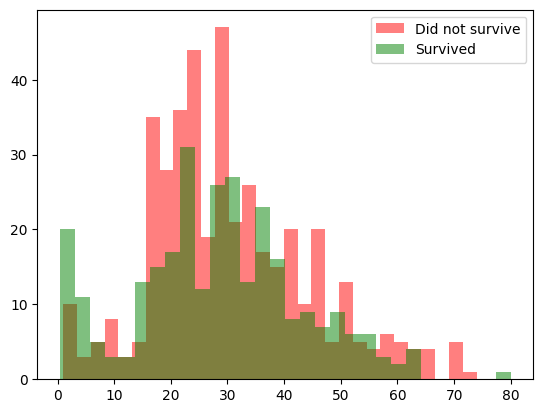

In [7]:
plt.hist(X[X["Survived"] == 0]["Age"],bins=30, color = "red", alpha = 0.5, label = "Did not survive")
plt.hist(X[X["Survived"] == 1]["Age"],bins=30, color = "green",alpha = 0.5, label = "Survived")
plt.legend()
plt.show()

This visualization shows that among young passengers (under 10), there is a clear peak in the number of survivors. This is likely because younger passengers were given priority during the evacuation. For passengers in their 20s and 30s, the trend is reversed, with a lower survival rate. Although the data is not scaled, it still provides a general idea of the overall distribution.

In [8]:
X["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


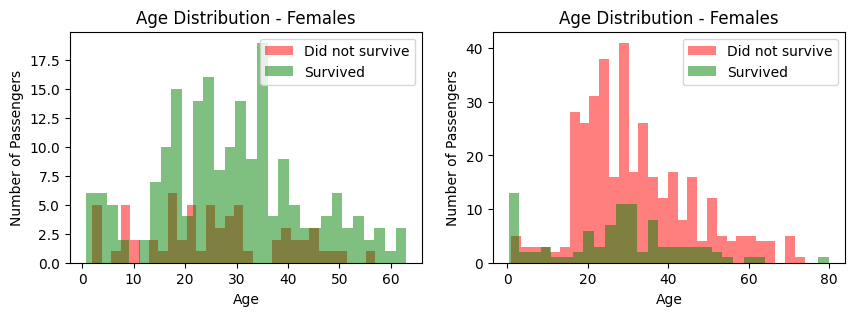

In [9]:
plt.figure(figsize = (10,3))
plt.subplot(1,2,1)
plt.hist(X[(X["Survived"] == 0) & (X["Sex"] == "female")]["Age"],bins=30, color = "red", alpha = 0.5, label = "Did not survive")
plt.hist(X[(X["Survived"] == 1) & (X["Sex"] == "female")]["Age"],bins=30, color = "green", alpha = 0.5, label = "Survived")
plt.title("Age Distribution - Females")
plt.xlabel("Age")
plt.ylabel("Number of Passengers")
plt.legend()
plt.subplot(1,2,2)
plt.hist(X[(X["Survived"] == 0) & (X["Sex"] == "male")]["Age"],bins=30, color = "red", alpha = 0.5, label = "Did not survive")
plt.hist(X[(X["Survived"] == 1) & (X["Sex"] == "male")]["Age"],bins=30, color = "green", alpha = 0.5, label = "Survived")
plt.title("Age Distribution - Females")
plt.xlabel("Age")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()

Based on these visualizations, we can see that sex is clearly a strong predictor of passenger survival. We will also drop rows with missing age values, as age is another strong predictor.

In [10]:
X["Age"] = X["Age"].fillna(X["Age"].median())
X["Fare"] = X["Fare"].fillna(X["Fare"].median())
X["Embarked"] = X["Embarked"].fillna(X["Embarked"].mode()[0])

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


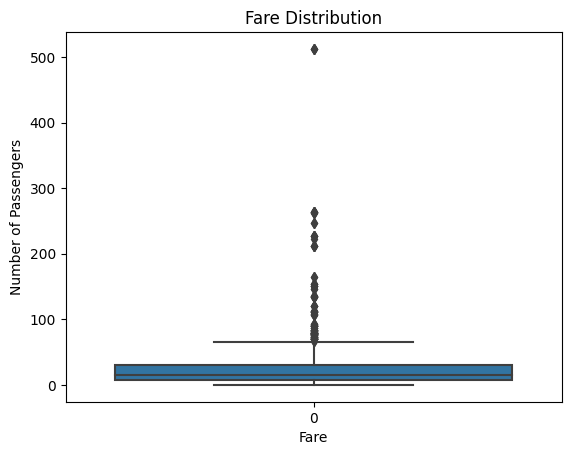

In [12]:
sns.boxplot(X["Fare"]) 
plt.title("Fare Distribution")       
plt.xlabel("Fare")                   
plt.ylabel("Number of Passengers")   
plt.show()

In [13]:
X["Fare_log"] = np.log1p(X["Fare"])

In [14]:
numerical_columns = list(X.select_dtypes(include = "number").columns)
numerical_columns[1], numerical_columns[7] = numerical_columns[7], numerical_columns[1]

<Axes: >

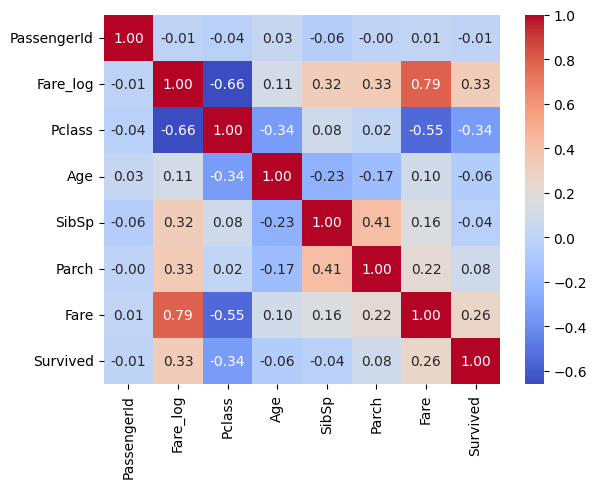

In [15]:
matrix = X[numerical_columns].corr()
sns.heatmap(matrix, annot = True, cmap="coolwarm", fmt = ".2f")

In [16]:
X.drop(columns = ["Fare","PassengerId"],inplace = True)

It's interesting to see that the ticket price is slightly correlated with the survival column. This might lead us to think that the more expensive the ticket, the higher the chance of survival. This feature is therefore quite interesting since ticket price is related to the passenger class, which is inversely correlated with the survival rate. In other words, expensive tickets usually mean first-class passengers, and class is inversely correlated with survival. It's important to keep these relationships in mind because they can introduce a sort of redundancy in the features. Indeed, if we give too much importance to multiple correlated features, we might end up emphasizing the same pattern multiple times, which could lead to overfitting.

# Preprocessing

In [17]:
X, y = X.drop(columns = ["Survived"]), X["Survived"]

In [18]:
# Label encoding 
categorical_columns = X.select_dtypes(exclude = "number").columns
label_encoders = {}
for col in categorical_columns : 
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
X.head(5)

,Pclass,Sex,Age,SibSp,Parch,Embarked,Fare_log
0,3,1,22.0,1,0,2,2.110213
1,1,0,38.0,1,0,0,4.280593
2,3,0,26.0,0,0,2,2.188856
3,1,0,35.0,1,0,2,3.990834
4,3,1,35.0,0,0,2,2.202765


In [19]:
sc = StandardScaler()
sc.fit(X)
X_scaled = sc.transform(X)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

In [21]:
features = X.columns

# Training

## Baseline : Logistic Reg

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
logr = LogisticRegression()
logr.fit(X_train, y_train)

LogisticRegression()

In [24]:
predicted = logr.predict(X_test)

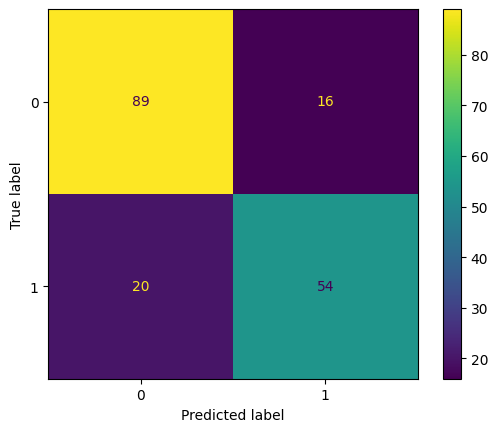

In [25]:
cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

In [26]:
print("recall_score = ",recall_score(y_test, predicted))
print("precision_score = ",precision_score(y_test, predicted))
print("f1_score = ",f1_score(y_test, predicted))

recall_score =  0.7297297297297297
precision_score =  0.7714285714285715
f1_score =  0.75


## Feature engineering

In [27]:
X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'Fare_log'], dtype='object')

In [28]:
X["IsAlone"] = X.apply(lambda x : 0 if (x["SibSp"] + x["Parch"]) > 0 else 1, axis = 1)
X["isYoung"] = X.apply(lambda x : 1 if (x["Age"] < 10) else 0, axis = 1)
features = X.columns

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Model development: Decision Tree

In [30]:
dtree = DecisionTreeClassifier(max_depth = 3, random_state = 42)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [31]:
predicted_tree = dtree.predict(X_test)

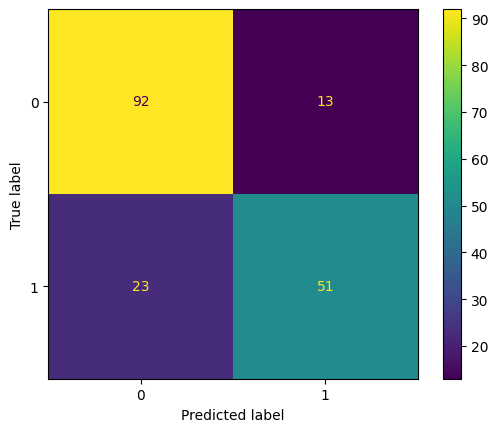

In [32]:
cm_tree = confusion_matrix(y_test, predicted_tree)
disp_tree = ConfusionMatrixDisplay(confusion_matrix = cm_tree)
disp_tree.plot()

In [33]:
print("recall_score = ",recall_score(y_test, predicted_tree))
print("precision_score = ",precision_score(y_test, predicted_tree))
print("f1_score = ",f1_score(y_test, predicted_tree))

recall_score =  0.6891891891891891
precision_score =  0.796875
f1_score =  0.7391304347826088


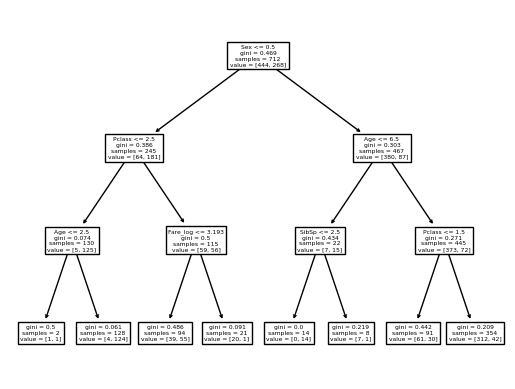

In [34]:
tree.plot_tree(dtree, feature_names=features, )
plt.show()

## Model development: Random Forest

In [35]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Embarked,Fare_log,IsAlone,isYoung
331,1,1,45.5,0,0,2,3.384390,1,0
733,2,1,23.0,0,0,2,2.639057,1,0
382,3,1,32.0,0,0,2,2.188856,1,0
704,3,1,26.0,1,0,2,2.180892,0,0
813,3,0,6.0,4,2,2,3.474293,0,1
...,...,...,...,...,...,...,...,...,...
106,3,0,21.0,0,0,2,2.157559,1,0
270,1,1,28.0,0,0,2,3.465736,1,0
860,3,1,41.0,2,0,2,2.715244,0,0
435,1,0,14.0,1,2,2,4.795791,0,0


In [36]:
rf = RandomForestClassifier( )
rf.fit(X_train, y_train)

RandomForestClassifier()

In [37]:
predicted_rf = rf.predict(X_test)

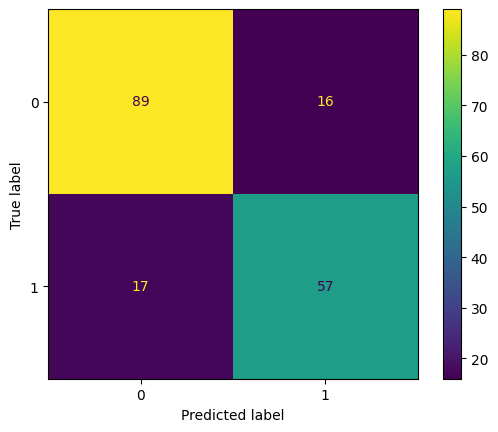

In [38]:
cm_tree = confusion_matrix(y_test, predicted_rf)
disp_tree = ConfusionMatrixDisplay(confusion_matrix = cm_tree)
disp_tree.plot()

In [39]:
print("recall_score = ",recall_score(y_test, predicted_rf))
print("precision_score = ",precision_score(y_test, predicted_rf))
print("f1_score = ",f1_score(y_test, predicted_rf))

recall_score =  0.7702702702702703
precision_score =  0.7808219178082192
f1_score =  0.7755102040816327


## Model development: LGBM Classifier

In [40]:
from lightgbm import LGBMClassifier, early_stopping

In [41]:
lgb = LGBMClassifier()

In [42]:
# %%
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 10],
    'num_leaves': [31, 50, 70],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
}

lgb = LGBMClassifier(
    device='gpu',
    random_state=42,
    verbose=-1
)

grid_search = GridSearchCV(
    lgb, 
    param_grid, 
    cv=2,  # Minimum obligatoire
    scoring='f1',
    n_jobs=1,
    verbose=0
)

grid_search.fit(X_train, y_train)

# %%
best_lgb = grid_search.best_estimator_
predicted_lgb = best_lgb.predict(X_test)

print(f"Meilleurs params: {grid_search.best_params_}")
print(f"F1-score: {f1_score(y_test, predicted_lgb):.4f}")

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Meilleurs params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 20, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.8}
F1-score: 0.7919


In [43]:
lgb.fit(X_train, y_train)

LGBMClassifier(device='gpu', random_state=42, verbose=-1)

In [44]:
best_lgb = grid_search.best_estimator_

In [45]:
predicted_lgb = best_lgb.predict(X_test)

print(f"Best params: {grid_search.best_params_}")

Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 20, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.8}


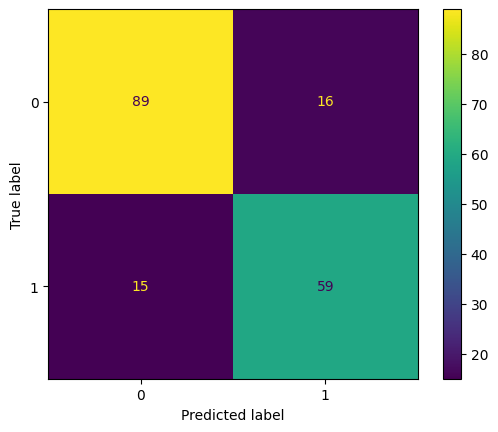

In [46]:
cm_tree = confusion_matrix(y_test, predicted_lgb)
disp_tree = ConfusionMatrixDisplay(confusion_matrix = cm_tree)
disp_tree.plot()

In [47]:
print("recall_score = ",recall_score(y_test, predicted_lgb))
print("precision_score = ",precision_score(y_test, predicted_lgb))
print("f1_score = ",f1_score(y_test, predicted_lgb))

recall_score =  0.7972972972972973
precision_score =  0.7866666666666666
f1_score =  0.7919463087248321


# Final submission

In [48]:
X_val = pd.read_csv("/kaggle/input/titanic/test.csv")

In [49]:
X_val["Age"] = X_val["Age"].fillna(X_val["Age"].median())
X_val["Fare"] = X_val["Fare"].fillna(X_val["Fare"].median())
X_val["Embarked"] = X_val["Embarked"].fillna(X_val["Embarked"].mode()[0])
X_val["Fare_log"] = np.log1p(X_val["Fare"])
PassengerId = X_val["PassengerId"]
X_val.drop(columns = ["Cabin","Name","Ticket","Fare","PassengerId"],inplace = True)

In [50]:
X_val["IsAlone"] = X_val.apply(lambda x : 0 if (x["SibSp"] + x["Parch"]) > 0 else 1, axis = 1)
X_val["isYoung"] = X_val.apply(lambda x : 1 if (x["Age"] < 10) else 1, axis = 1)

In [51]:
# Label encoding 
for col in categorical_columns : 
    X_val[col] = label_encoders[col].transform(X_val[col])
X_val

,Pclass,Sex,Age,SibSp,Parch,Embarked,Fare_log,IsAlone,isYoung
0,3,1,34.5,0,0,1,2.178064,1,1
1,3,0,47.0,1,0,2,2.079442,0,1
2,2,1,62.0,0,0,1,2.369075,1,1
3,3,1,27.0,0,0,2,2.268252,1,1
4,3,0,22.0,1,1,2,2.586824,0,1
...,...,...,...,...,...,...,...,...,...
413,3,1,27.0,0,0,2,2.202765,1,1
414,1,0,39.0,0,0,0,4.699571,1,1
415,3,1,38.5,0,0,2,2.110213,1,1
416,3,1,27.0,0,0,2,2.202765,1,1


In [52]:
final_prediction = best_lgb.predict(X_val)

In [53]:
result_df = pd.DataFrame({
    "PassengerId":PassengerId,
    "Survived":final_prediction
})
result_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0


In [54]:
result_df.to_csv("my_submission.csv", index = False)